# Exploration 5. Ï∫êÍ∏Ä ÎßõÏùÑ Î≥¥Ïûê

## 0. Í∏∞Î≥∏Ï§ÄÎπÑ

In [1]:
import os
import glob
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
!pip install jupyterthemes
from jupyterthemes import get_themes
import jupyterthemes as jt
from jupyterthemes.stylefx import set_nb_theme

set_nb_theme('onedork')

In [3]:
plt.style.use(['dark_background'])

In [4]:
!pwd

/aiffel/aiffel/Exploration/lets_kaggle


In [5]:
!mkdir -p /aiffel/aiffel/Exploration/lets_kaggle/kaggle_kakr_housing

In [6]:
path = '/aiffel/aiffel/Exploration/lets_kaggle/kaggle_kakr_housing/'

In [7]:
dir_path = '/aiffel/aiffel/Exploration/lets_kaggle/kaggle_kakr_housing/data/'

## kaggle?
:Îç∞Ïù¥ÌÑ∞ ÏÇ¨Ïù¥Ïñ∏Ìã∞Ïä§Ìä∏Îì§ÏùÑ ÏúÑÌïú Í≤ΩÏßÑÎåÄÌöå ÏÇ¨Ïù¥Ìä∏

1. Description, ÎåÄÌöå ÏÜåÍ∞ú
    - Ï∫êÍ∏ÄÏùò Îã§ÏñëÌïú Í≤ΩÏßÑÎåÄÌôîÎì§ÏùÄ Î™®Îëê ÎåÄÌöå ÏÜåÍ∞úÏôÄ ÏÑ∏Î∂Ä Í∑úÏπô ÏïàÎÇ¥ÏùÑ Íµ¨ÏÑ±ÏùÑ Í∞ñÏ∂îÍ≥† ÏûàÎã§.
    - ÎãπÏó∞Ìûà ÎåÄÌöåÎ≥ÑÎ°ú Í∑úÏπôÏù¥ ÏÉÅÏù¥Ìï®

2. Evaluation, Ï†êÏàò ÌèâÍ∞Ä Í∏∞Ï§Ä
    - Ïó¨Í∏∞ÏÑú Î™®ÏùòÎ°ú Ï∞∏Í∞ÄÌï¥ Î≥º ÎåÄÌöåÏùò Í∏∞Ï§ÄÏùÄ RMSE
    - RMSE : ÌèâÍ∑† Ï†úÍ≥±Í∑º Ïò§Ï∞®(= ÌèâÍ∑† Ï†úÍ≥±Í∑º Ìé∏Ï∞®)
    > https://ko.wikipedia.org/wiki/%ED%8F%89%EA%B7%A0_%EC%A0%9C%EA%B3%B1%EA%B7%BC_%ED%8E%B8%EC%B0%A8
    
3. ÏÉÅÌíà / Í∑úÏπô ÏÑ§Î™Ö Îì±..

In [8]:
!mkdir -p /aiffel/aiffel/Exploration/lets_kaggle/kaggle_kakr_housing/data

In [9]:
!ln -s ~/data/data/*.csv /aiffel/aiffel/Exploration/lets_kaggle/kaggle_kakr_housing/data

ln: failed to create symbolic link '/aiffel/aiffel/Exploration/lets_kaggle/kaggle_kakr_housing/data/sample_submission.csv': File exists
ln: failed to create symbolic link '/aiffel/aiffel/Exploration/lets_kaggle/kaggle_kakr_housing/data/test.csv': File exists
ln: failed to create symbolic link '/aiffel/aiffel/Exploration/lets_kaggle/kaggle_kakr_housing/data/train.csv': File exists


In [10]:
os.listdir(dir_path)

['submission_lgbm_RMSLE_0.01608.csv',
 'submission_lgbm_RMSLE_0.164399.csv',
 'submission_lgbm_RMSLE_0.160873.csv',
 'submission_lgbm_RMSLE_0.0168.csv',
 'sample_submission.csv',
 'submission.csv',
 'train.csv',
 'test.csv']

In [11]:
train_data_path = join(dir_path, 'train.csv')
test_data_path = join(dir_path, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

## 1. Îç∞Ïù¥ÌÑ∞ Ï†ÑÏ≤òÎ¶¨

### Data fields(Ïª¨Îüº)
<ol>
    <li>ID : ÏßëÏùÑ Íµ¨Î∂ÑÌïòÎäî Î≤àÌò∏</li>
<li>date : ÏßëÏùÑ Íµ¨Îß§Ìïú ÎÇ†Ïßú
<li>price : ÏßëÏùò Í∞ÄÍ≤©(Target variable)
<li>bedrooms : Ïπ®Ïã§Ïùò Ïàò
<li>bathrooms : ÌôîÏû•Ïã§Ïùò Ïàò
<li>sqft_living : Ï£ºÍ±∞ Í≥µÍ∞ÑÏùò ÌèâÎ∞© ÌîºÌä∏(Î©¥Ï†Å)
<li>sqft_lot : Î∂ÄÏßÄÏùò ÌèâÎ∞© ÌîºÌä∏(Î©¥Ï†Å)
<li>floors : ÏßëÏùò Ï∏µ Ïàò
<li>waterfront : ÏßëÏùò Ï†ÑÎ∞©Ïóê Í∞ïÏù¥ ÌùêÎ•¥ÎäîÏßÄ Ïú†Î¨¥ (a.k.a. Î¶¨Î≤ÑÎ∑∞)
<li>view : ÏßëÏù¥ ÏñºÎßàÎÇò Ï¢ãÏïÑ Î≥¥Ïù¥ÎäîÏßÄÏùò Ï†ïÎèÑ
<li>condition : ÏßëÏùò Ï†ÑÎ∞òÏ†ÅÏù∏ ÏÉÅÌÉú
<li>grade : King County grading ÏãúÏä§ÌÖú Í∏∞Ï§ÄÏúºÎ°ú Îß§Í∏¥ ÏßëÏùò Îì±Í∏â
<li>sqft_above : ÏßÄÌïòÏã§ÏùÑ Ï†úÏô∏Ìïú ÌèâÎ∞© ÌîºÌä∏(Î©¥Ï†Å)
<li>sqft_basement : ÏßÄÌïòÏã§Ïùò ÌèâÎ∞© ÌîºÌä∏(Î©¥Ï†Å)
<li>yr_built : ÏßÄÏñ¥ÏßÑ ÎÖÑÎèÑ
<li>yr_renovated : ÏßëÏùÑ Ïû¨Í±¥Ï∂ïÌïú ÎÖÑÎèÑ
<li>zipcode : Ïö∞Ìé∏Î≤àÌò∏
<li>lat : ÏúÑÎèÑ
<li>long : Í≤ΩÎèÑ
<li>sqft_living15 : 2015ÎÖÑ Í∏∞Ï§Ä Ï£ºÍ±∞ Í≥µÍ∞ÑÏùò ÌèâÎ∞© ÌîºÌä∏(Î©¥Ï†Å, ÏßëÏùÑ Ïû¨Í±¥Ï∂ïÌñàÎã§Î©¥, Î≥ÄÌôîÍ∞Ä ÏûàÏùÑ Ïàò ÏûàÏùå)
<li>sqft_lot15 : 2015ÎÖÑ Í∏∞Ï§Ä Î∂ÄÏßÄÏùò ÌèâÎ∞© ÌîºÌä∏(Î©¥Ï†Å, ÏßëÏùÑ Ïû¨Í±¥Ï∂ïÌñàÎã§Î©¥, Î≥ÄÌôîÍ∞Ä ÏûàÏùÑ Ïàò ÏûàÏùå)   
</ol>

### Data Explorer - Îç∞Ïù¥ÌÑ∞ ÌååÏùº
- train.csv : Î™®Îç∏ ÌïôÏäµÏö© ÌååÏùº
- test.csv : ÌÖåÏä§Ìä∏Ïö© ÌååÏùº
- sample_submission.csv : Ï†úÏ∂úÏö© ÌååÏùº
>Ïö∞Î¶¨Îäî train.csvÎ•º ÌôúÏö©Ìï¥ÏÑú Îç∞Ïù¥ÌÑ∞Î•º ÎúØÏñ¥Î≥¥Í≥† Î™®Îç∏ÏùÑ ÌïôÏäµÏãúÌÇ® ÌõÑ, test.csv ÌååÏùºÏùò Îç∞Ïù¥ÌÑ∞Ïóê ÎåÄÌï¥ priceÎ•º ÏòàÏ∏°Ìï¥ÏÑú sample_submission.csvÏùò ÌòïÏãùÏóê ÎßûÎäî ÌòïÌÉúÎ°ú Ï∫êÍ∏ÄÏóê Ï†úÏ∂úÏùÑ Ìï¥Î≥º Í≤ÉÏûÖÎãàÎã§.


### Baseline?
- Ìï¥Îãπ ÎåÄÌöåÏùò Í≤ΩÏö∞ Î≤†Ïù¥Ïä§ÎùºÏù∏ÏùÑ Ï†úÍ≥µÌïúÎã§.
- Î≤†Ïù¥Ïä§ÎùºÏù∏ÏùÄ Í∏∞Î≥∏ Î¨∏Ï†ú Ìï¥Í≤∞ Î∞©Ìñ•ÏùÑ Ï†úÏãúÌïòÎäî ÏÉòÌîå

Ïù¥ÎØ∏ ÏûëÏÑ±Îêú Î≥ÑÎèÑÏùò Ïª§ÎÑêÏóêÏÑú ÏßÑÌñâÌï¥Î≥º Í≤É.

### ÏïôÏÉÅÎ∏î(Î∏îÎ†åÎî©) Í∏∞Î≤ïÏùÄ Î¨¥ÏõüÏù∏Í∞Ä?
> https://subinium.github.io/introduction-to-ensemble-1/#:~:text=%EC%95%99%EC%83%81%EB%B8%94(Ensemble)%20%ED%95%99%EC%8A%B5%EC%9D%80%20%EC%97%AC%EB%9F%AC,%EB%A5%BC%20%EA%B0%80%EC%A7%80%EA%B3%A0%20%EC%9D%B4%ED%95%B4%ED%95%98%EB%A9%B4%20%EC%A2%8B%EC%8A%B5%EB%8B%88%EB%8B%A4.

### Îç∞Ïù¥ÌÑ∞ ÌôïÏù∏ Î∞è Ï†ÑÏ≤òÎ¶¨

In [12]:
train.head()

id             date     price  bedrooms  bathrooms  sqft_living  sqft_lot  \
0   0  20141013T000000  221900.0         3       1.00         1180      5650   
1   1  20150225T000000  180000.0         2       1.00          770     10000   
2   2  20150218T000000  510000.0         3       2.00         1680      8080   
3   3  20140627T000000  257500.0         3       2.25         1715      6819   
4   4  20150115T000000  291850.0         3       1.50         1060      9711   

   floors  waterfront  view  ...  grade  sqft_above  sqft_basement  yr_built  \
0     1.0           0     0  ...      7        1180              0      1955   
1     1.0           0     0  ...      6         770              0      1933   
2     1.0           0     0  ...      8        1680              0      1987   
3     2.0           0     0  ...      7        1715              0      1995   
4     1.0           0     0  ...      7        1060              0      1963   

   yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15  
0             0    98178  47.5112 -122.257           1340        5650  
1             0    98028  47.7379 -122.233           2720        8062  
2             0    98074  47.6168 -122.045           1800        7503  
3             0    98003  47.3097 -122.327           2238        6819  
4             0    98198  47.4095 -122.315           1650        9711  

[5 rows x 21 columns]

In [13]:
### dateÎ•º 6ÏûêÎ¶¨ Ï†ïÏàòÌòïÏúºÎ°ú Î≥ÄÌôò
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
train.head()

id    date     price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
0   0  201410  221900.0         3       1.00         1180      5650     1.0   
1   1  201502  180000.0         2       1.00          770     10000     1.0   
2   2  201502  510000.0         3       2.00         1680      8080     1.0   
3   3  201406  257500.0         3       2.25         1715      6819     2.0   
4   4  201501  291850.0         3       1.50         1060      9711     1.0   

   waterfront  view  ...  grade  sqft_above  sqft_basement  yr_built  \
0           0     0  ...      7        1180              0      1955   
1           0     0  ...      6         770              0      1933   
2           0     0  ...      8        1680              0      1987   
3           0     0  ...      7        1715              0      1995   
4           0     0  ...      7        1060              0      1963   

   yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15  
0             0    98178  47.5112 -122.257           1340        5650  
1             0    98028  47.7379 -122.233           2720        8062  
2             0    98074  47.6168 -122.045           1800        7503  
3             0    98003  47.3097 -122.327           2238        6819  
4             0    98198  47.4095 -122.315           1650        9711  

[5 rows x 21 columns]

In [14]:
y = train['price']  # Î≥ÄÏàòyÏóê priceÎ•º Îã¥ÏïÑÎëêÍ≥†
del train['price']  # trainÏùò Ïª¨ÎüºÏóêÏÑú Ï†úÍ±∞

print(train.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [15]:
del train['id']  # idÎèÑ Ï†úÍ±∞Ìï¥Ï£ºÏûê

print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [16]:
# ÌÖåÏä§Ìä∏Îç∞Ïù¥ÌÑ∞ÏóêÎèÑ Í∞ôÏùÄ Í≥ºÏ†ïÏùÑ Í±∞ÏπúÎã§. Îã® id(ÎùºÎ≤®ÎßÅ)Îäî ÎãπÏó∞Ìûà ÏóÜÏúºÎãà Í≥ºÏ†ïÏóêÏÑú Îπ†Ïßê
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

del test['id']

print(test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [17]:
# ÌÉÄÍ≤üÎç∞Ïù¥ÌÑ∞Ïù∏ 'Í∞ÄÍ≤©'ÏùÑ ÌôïÏù∏Ìï¥Î≥¥Ïûê. ÏàòÏπòÍ∞Ä ÌÅ¨Îã§.
y

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64

###  seabornÏùò kdeplot
: Ïù¥ÏÇ∞(discrete) Îç∞Ïù¥ÌÑ∞Ïùò Í≤ΩÏö∞ÏóêÎèÑ Î∂ÄÎìúÎü¨Ïö¥ Í≥°ÏÑ†ÏúºÎ°ú Ï†ÑÏ≤¥ Î∂ÑÌè¨Î•º ÌôïÏù∏Ìï† Ïàò ÏûàÎèÑÎ°ù ÌïòÎäî ÏãúÍ∞ÅÌôî Ìï®ÏàòÏûÖÎãàÎã§.

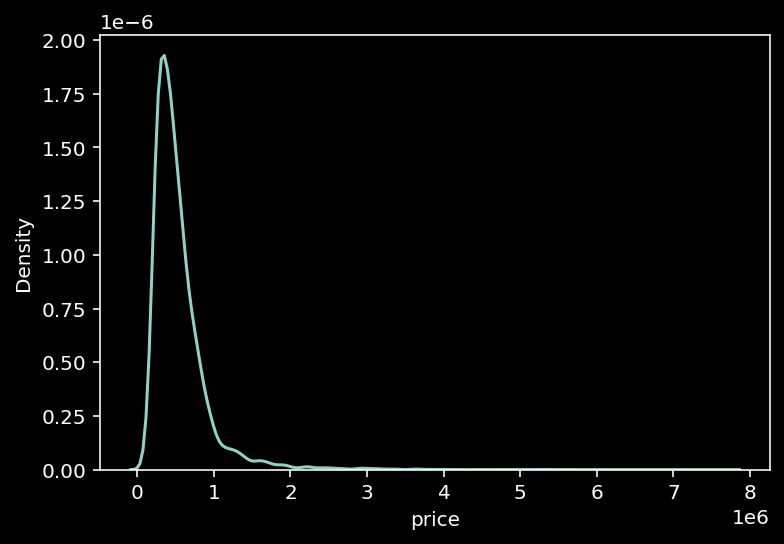

In [18]:
# Î∂ÑÌè¨Í∞Ä Î™∞Î†§ÏûàÎã§.
sns.kdeplot(y)
plt.show()

In [19]:
# Ï†ïÍ∑úÎ∂ÑÌè¨ ÌòïÌÉúÎ°ú ÎÇòÌÉÄÎÇ† Ïàò ÏûàÍ≤å logÍ∞íÏúºÎ°ú Î≥ÄÌôòÌï¥Ï§ÄÎã§.
# ÏóêÏ∏°Ïù¥ ÎÅùÎÇú ÌõÑÏóêÎäî np.exp1m() Ìï®ÏàòÎ°ú ÎêòÎèåÎ†§Ï§Ä Îã§Ïùå ÌôïÏù∏ÌïòÎ©¥ Îê† Í≤É

# np.exp1m()ÏùÄ np.log1p()Í≥ºÎäî Î∞òÎåÄÎ°ú Í∞Å ÏõêÏÜå xÎßàÎã§ exp(x)-1Ïùò Í∞íÏùÑ Î∞òÌôòÌï¥ Ï§çÎãàÎã§.

y = np.log1p(y)
y

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

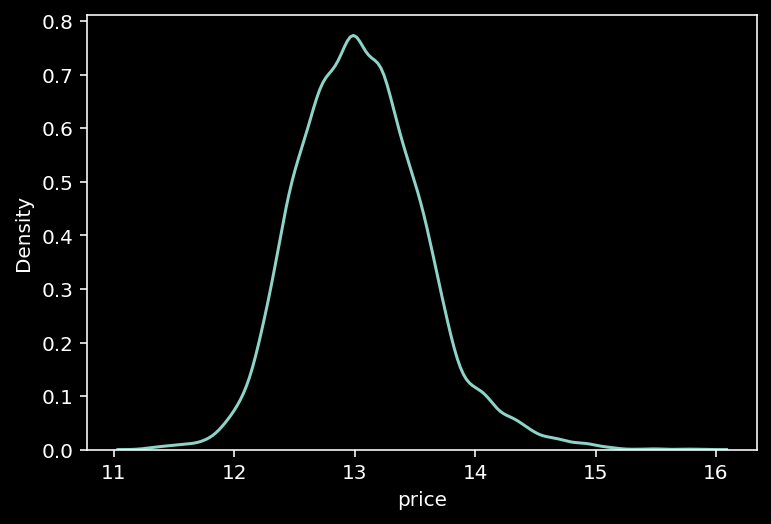

In [20]:
# Î∂ÑÌè¨Í∞Ä ÎπÑÍµêÏ†Å Í≥†Î•¥Í≤å ÎÇòÌÉÄÎÇ®.
sns.kdeplot(y)
plt.show()

In [21]:
# info()Î©îÏÜåÎìúÎ°ú Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞Ïùò ÏûêÎ£åÌòïÏùÑ Ìïú ÎààÏóê ÌôïÏù∏Ìï¥Î≥¥Ïûê 
# Îç∞Ïù¥ÌÑ∞ÌÉÄÏûÖÏù¥ Ï†ïÏàò ÎòêÎäî Ïã§ÏàòÎ°ú Íµ¨ÏÑ±ÎêòÏñ¥ ÏûàÏúºÎãà, Î™®Îç∏ ÌïôÏäµÏóê ÏûàÏñ¥ ÏßÄÏû•Ïù¥ ÏóÜÏùÑ Í≤É Í∞ôÎã§.
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

## 2. Î™®Îç∏Ïùò Ï†ïÌôïÎèÑÎ•º Ìñ•ÏÉÅÏãúÏºúÎ≥¥Ïûê

### 2.1. Î∞òÎ≥µÏ†ÅÏúºÎ°ú ÏàòÌñâÌï† ÏûëÏóÖÏùÑ ÏúÑÌïú Ìï®Ïàò ÏÉùÏÑ±

### RMSEÍ≥ÑÏÇ∞

In [22]:
#ÌïÑÏöîÌïú ÎùºÏù¥Î∏åÎü¨Î¶¨ Í∞ÄÏ†∏Ïò§Í∏∞
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

y_tes, y_predÎäî Ïä§ÏºÄÏùºÎßÅ Îêú yÍ∞íÏùÑ Í∏∞Ï§ÄÏúºÎ°ú ÎêòÏñ¥ÏûàÏúºÎãà Îç∞Ïù¥ÌÑ∞Î•º ÏõêÎ≥∏ ÌòïÌÉúÎ°ú ÎêòÎèåÎ¶∞ Îã§Ïùå Í≥ÑÏÇ∞Ìï¥Ïïº ÌïúÎã§.

In [23]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [24]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

print('Ïñçüí¢')

Ïñçüí¢


In [25]:
# random_stateÎäî Î™®Îç∏Ï¥àÍ∏∞ÌôîÎÇò Îç∞Ïù¥ÌÑ∞ÏÖã Íµ¨ÏÑ±Ïóê ÏÇ¨Ïö©ÎêòÎäî ÎûúÎç§ ÏãúÎìúÍ∞íÏûÖÎãàÎã§. 
#random_state=None    # Ïù¥Í≤å Ï¥àÍ∏∞Í∞íÏûÖÎãàÎã§. ÏïÑÎ¨¥Í≤ÉÎèÑ ÏßÄÏ†ïÌïòÏßÄ ÏïäÍ≥† NoneÏùÑ ÎÑòÍ≤®Ï£ºÎ©¥ Î™®Îç∏ ÎÇ¥Î∂ÄÏóêÏÑú ÏûÑÏùòÎ°ú ÏÑ†ÌÉùÌï©ÎãàÎã§.  
random_state=2020        # ÌïòÏßÄÎßå Ïö∞Î¶¨Îäî Ïù¥Î†áÍ≤å Í≥†Ï†ïÍ∞íÏùÑ ÏÑ∏ÌåÖÌï¥ ÎëêÍ≤†ÏäµÎãàÎã§. 

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

print('Ïñçüí¢')

Ïñçüí¢


In [26]:
# Í∞Å Î™®Îç∏Ïùò Ïù¥Î¶Ñ ÌôïÏù∏
gboost.__class__.__name__
# ÌíÄÎÑ§ÏûÑ(?)ÏùÑ ÏïåÏïÑÏïº ÌÅ¥ÎûòÏä§ÎÇò Ìï®Ïàò, Î∞òÎ≥µÎ¨∏ Îì±ÏóêÏÑú ÏûêÏú†Î°≠Í≤å ÏÇ¨Ïö©Ìï† Ïàò ÏûàÎã§.

'GradientBoostingRegressor'

In [27]:
df = {}

for model in models:
    # Î™®Îç∏ Ïù¥Î¶Ñ ÌöçÎìù
    model_name = model.__class__.__name__

    # train, test Îç∞Ïù¥ÌÑ∞ÏÖã Î∂ÑÎ¶¨ - Ïó¨Í∏∞ÏóêÎèÑ random_stateÎ•º Í≥†Ï†ïÌï©ÎãàÎã§. 
    X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)

    # Î™®Îç∏ ÌïôÏäµ
    model.fit(X_train, y_train)
    
    # ÏòàÏ∏°
    y_pred = model.predict(X_test)

    # ÏòàÏ∏° Í≤∞Í≥ºÏùò rmseÍ∞í Ï†ÄÏû•
    df[model_name] = rmse(y_test, y_pred)
    
    # data frameÏóê Ï†ÄÏû•
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    
df

{'GradientBoostingRegressor': 128360.19649691365,
 'XGBRegressor': 110318.66956616656,
 'LGBMRegressor': 111920.36735892233,
 'RandomForestRegressor': 125487.07102453562}

In [28]:
# ÏúÑÏùò Í≥ºÏ†ïÏùÑ Ìï®ÏàòÎ°ú Ï∂ïÏïΩ. Î∏îÎ†åÎî©Ìï† Î™®Îç∏Î¶¨Ïä§Ìä∏, ÌïôÏäµÎç∞Ïù¥ÌÑ∞, ÌÉÄÍ≤üÎç∞Ïù¥ÌÑ∞Î•º Ïù∏ÏûêÎ°ú Î∞õÎäîÎã§.

def get_scores(models, train, y):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df

### 2.2. ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞ ÌäúÎãù


- ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞Îäî Î™®Îç∏Ïù¥ ÌïôÏäµÌïòÍ∏∞ Ï†Ñ, ÏûÑÏùòÎ°ú Ï°∞Ï†àÌï¥ Ï§Ñ Ïàò ÏûàÎäî ÏàòÏπòÎ•º Ìè¨Ìï®Ìïú Î≥ÄÏàòÎì§(?)Ïù¥Îã§.
- epoch, batch_size Îì±Ïù¥ ÏûàÏùå.
- Ïù¥ Ïã§ÏäµÏóêÏÑúÎäî ÏÇ¨Ïù¥ÌÇ∑Îü∞Ïùò GridSerchCV ÌÅ¥ÎûòÏä§Î•º ÌôúÏö©ÌïúÎã§.

In [29]:
from sklearn.model_selection import GridSearchCV

print('Ïñçüí¢')

Ïñçüí¢


### GridSearchCVÎûÄ?

- Í∑∏Î¶¨Îìú ÌÉêÏÉâÍ≥º ÎûúÎç§ ÌÉêÏÉâ
    - Í∑∏Î¶¨Îìú ÌÉêÏÉâ : ÌïòÏù¥Ìçº ÌååÎùºÎØ∏ÌÑ∞Ïùò Í∞íÏùÑ ÎØ∏Î¶¨ ÏÑ§Ï†ï. Í∑∏ Í∞íÎì§Î°ú Ï°∞Ìï©Îê† Ïàò ÏûàÎäî Î™®Îì† Í≤ΩÏö∞Î•º ÌÉêÏÉâ.
    - ÎûúÎç§ ÌÉêÏÉâ : ÌÉêÏÉâÌï† ÌååÎùºÎØ∏ÌÑ∞Ïùò ÏòÅÏó≠Îßå ÏÑ§Ï†ï. ÏµúÏ†ÅÏùò Ï°∞Ìï©ÏùÑ Ï∞æÏùÑ Ïàò'ÎèÑ' ÏûàÏúºÎÇò Í≥ºÏ†ïÏùÑ ÌååÏïÖÌï† Ïàò ÏóÜÎã§. 
    

- GridSearchCVÎäî ÎãπÏó∞Ìûà Í∑∏Î¶¨Îìú ÌÉêÏÉâÏù¥Îã§.
- GridSearchCVÏùò Ïù∏ÏûêÎì§ 
    - param_grid : ÌÉêÏÉâÌï† ÌååÎùºÎØ∏ÌÑ∞Ïùò Ï¢ÖÎ•ò (ÎîïÏÖîÎÑàÎ¶¨Î°ú ÏûÖÎ†•)
    - scoring : Î™®Îç∏Ïùò ÏÑ±Îä•ÏùÑ ÌèâÍ∞ÄÌï† ÏßÄÌëú
    - cv : cross validationÏùÑ ÏàòÌñâÌïòÍ∏∞ ÏúÑÌï¥ train Îç∞Ïù¥ÌÑ∞ÏÖãÏùÑ ÎÇòÎàÑÎäî Ï°∞Í∞ÅÏùò Í∞úÏàò
    - verbose : Í∑∏Î¶¨Îìú ÌÉêÏÉâÏùÑ ÏßÑÌñâÌïòÎ©¥ÏÑú ÏßÑÌñâ Í≥ºÏ†ïÏùÑ Ï∂úÎ†•Ìï¥ÏÑú Î≥¥Ïó¨Ï§Ñ Î©îÏÑ∏ÏßÄÏùò Ïñë (Ïà´ÏûêÍ∞Ä ÌÅ¥ÏàòÎ°ù Îçî ÎßéÏùÄ Î©îÏÑ∏ÏßÄÎ•º Ï∂úÎ†•Ìï©ÎãàÎã§.)
    - n_jobs : Í∑∏Î¶¨Îìú ÌÉêÏÉâÏùÑ ÏßÑÌñâÌïòÎ©¥ÏÑú ÏÇ¨Ïö©Ìï† CPUÏùò Í∞úÏàò

In [30]:
# ÏµúÏ†ÅÌôî Ìï¥ Î≥º ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞ÏôÄ Í∑∏Î¶¨Îìú(Í∞í)

param_grid = { 
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

LMSÏóêÎäî xgboost Í¥ÄÎ†® ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞ ÎùºÍ≥† ÌñàÏßÄÎßå ÏïÑÎûò ÏΩîÎìúÎ•º Î≥¥Î©¥ Îî±Ìûà xgboostÎ•º ÏóºÎëêÏóê Îëî Í≤É Í∞ôÏßÄÎäî ÏïäÎã§.

Îã§Îßå n_estimators(ÏïΩÌïú ÌïôÏäµÍ∏∞ Í∞ØÏàò)ÏôÄ max_depth(ÌïôÏäµ Î∂ÑÍ∏∞Ïùò ÏµúÎåÄ ÍπäÏù¥)Îäî<br>
ÏïûÏÑú Î¶¨Ïä§ÌåÖÌïú modelsÏùò Î™®Îç∏Îì§ÏóêÏÑú Í≥µÌÜµÏ†ÅÏúºÎ°ú ÏÇ¨Ïö©ÌïòÎäî Í≤ÉÏúºÎ°ú Î≥¥Ïù∏Îã§.

In [31]:
# LGBMRegressor Î™®Îç∏Ïóê ÎåÄÌïú ÌäúÎãùÏùÑ ÏßÑÌñâÌï¥Î≥¥Ïûê.
model = LGBMRegressor(random_state=random_state)

In [32]:
grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)

grid_model.fit(train, y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=2020), n_jobs=5,
             param_grid={'max_depth': [1, 10], 'n_estimators': [50, 100]},
             scoring='neg_mean_squared_error', verbose=1)

In [33]:
# Î™®Îç∏Ïóê ÎåÄÌïú Í∑∏Î¶¨Îìú ÌÉêÏÉâÏùò (ÍµêÏ∞®Í≤ÄÏ¶ù)Í≤∞Í≥º
grid_model.cv_results_

{'mean_fit_time': array([0.14018769, 0.22638087, 0.47203746, 0.59817328]),
 'std_fit_time': array([0.01141696, 0.07556902, 0.15661518, 0.07956844]),
 'mean_score_time': array([0.00745854, 0.01396375, 0.02442622, 0.03507509]),
 'std_score_time': array([0.00028464, 0.00610469, 0.00844598, 0.01091608]),
 'param_max_depth': masked_array(data=[1, 1, 10, 10],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[50, 100, 50, 100],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 1, 'n_estimators': 50},
  {'max_depth': 1, 'n_estimators': 100},
  {'max_depth': 10, 'n_estimators': 50},
  {'max_depth': 10, 'n_estimators': 100}],
 'split0_test_score': array([-0.0756974 , -0.05555652, -0.02885847, -0.02665428]),
 'split1_test_score': array([-0.07666447, -0.057876  , -0.03041465, -0.02795896]),
 'split2_test_score': array([-0.07354904

ÏúÑ Îç∞Ïù¥ÌÑ∞Ïùò Í∞íÏù¥ Î≥µÏû°ÌïòÎãà ÏõêÌïòÎäî Ï†ïÎ≥¥Îßå Ïó¥ÎûåÌï¥Î≥¥Ïûê.
- Ïö∞Î¶¨Ïùò Î™©ÌëúÎäî Ïñ¥Îñ§ ÌååÎùºÎØ∏ÌÑ∞ Í∞íÏóêÏÑú ÎÜíÏùÄ Ï†êÏàòÎ•º ÏñªÎäîÍ∞Ä Ïù¥Îã§.
- Ïö∞ÏÑ† ÌååÎùºÎØ∏ÌÑ∞ Í∞íÏùò Ï°∞Ìï©Í≥º ÌÖåÏä§Ìä∏ Ï†êÏàòÎùºÎäî Îëê ÎùºÎ≤®Îßå Ï∂îÏ∂úÌï¥Î≥¥Ïûê

In [34]:
params = grid_model.cv_results_['params']
params

[{'max_depth': 1, 'n_estimators': 50},
 {'max_depth': 1, 'n_estimators': 100},
 {'max_depth': 10, 'n_estimators': 50},
 {'max_depth': 10, 'n_estimators': 100}]

In [35]:
score = grid_model.cv_results_['mean_test_score']
score

array([-0.07339447, -0.05502043, -0.02917734, -0.02702714])

In [36]:
#Ìïò.. ÌåêÎã§Ïä§ Î∞∞Ïö∞Í∏∞ ÎÖ∏Ïûº
results = pd.DataFrame(params)
results['score'] = score

results

max_depth  n_estimators     score
0          1            50 -0.073394
1          1           100 -0.055020
2         10            50 -0.029177
3         10           100 -0.027027

Ïñ¥ÎñªÍ≤å.. ÌèâÍ∞Ä Ï†êÏàòÍ∞Ä.. ÏùåÏàò..?!

- Ïï†Ï¥àÏóê Ï†Ä Ï†êÏàòÎäî Î¨¥ÏóáÏù∏Í∞Ä?
: scoring='neg_mean_squared_error'


- Ïôú ÏùåÏàòÎ°ú Ï†êÏàòÎ•º ÎÇ¥ÎäîÍ∞Ä?
    - Ïä§ÏΩîÏñ¥Îäî ÎÜíÏùÄ Í≤ÉÏù¥ ÌõåÎ•≠Ìïú Í≤É
    - Ïù¥ Í≤ΩÏö∞ Î™®Îç∏Ïùò ÌååÎùºÎØ∏ÌÑ∞ÏôÄ ÌÖåÏä§Ìä∏ Í≤∞Í≥ºÍ∞íÏùò Í±∞Î¶¨(Ï∞®)Í∞Ä Ï¢ÅÏùÑÏàòÎ°ù ÌõåÎ•≠
    - ÏûëÏùÄ Ïà´ÏûêÍ∞Ä Îçî Í≥†ÎìùÏ†êÏù∏ Í≤ÉÏùÄ Ï∞∏ÏùÑ Ïàò ÏóÜÏúºÎãà ÏùåÏàòÎ°ú Î∞îÍøîÏ§ÄÎã§
    - Í≤∞Í≥ºÏ†ÅÏúºÎ°ú Îçî ÌÅ∞ Ïà´Ïûê(0Ïóê Í∞ÄÍπåÏö¥..)Í∞Ä Í≥†ÎìùÏ†êÏù¥ ÎêúÎã§.


- Ï¢Ä ÏßúÏ¶ùÎÇòÏßÄÎßå Ïù¥Ïú†Í∞Ä ÏûàÍ≤†Ï£†... Ïóê..



In [37]:
#ÏñëÏàòÎ°ú Î∞îÍæ∏Í≥† Î£®Ìä∏ Ïó∞ÏÇ∞ÏùÑ Ìï¥Ï£ºÎ©¥ ÏßúÏûî
results['RMSE'] = np.sqrt(-1 * results['score'])
results

max_depth  n_estimators     score      RMSE
0          1            50 -0.073394  0.270914
1          1           100 -0.055020  0.234564
2         10            50 -0.029177  0.170814
3         10           100 -0.027027  0.164399

In [38]:
# Ï†êÏàòÍ∞Ä ÏßúÍµ¨ÎÇò.. 
# Ïù¥Ïú†Îäî Ïù¥ÎØ∏ Ìïú Î≤à Î°úÍ∑∏Ìï®ÏàòÎ°ú Ïä§ÏºÄÏùºÎßÅÌïú ÌÉÄÍ≤ü Îç∞Ïù¥ÌÑ∞Î•º Í∏∞Ï§ÄÏúºÎ°ú ÌñàÍ∏∞ ÎñÑÎ¨∏
# ÏßÄÍ∏à ÏòàÏ∏°Í∞íÏùÑ Î≥¥Í∏∞ Î≥¥Îã§Îäî Ïù¥Î¶ÑÏùÑ Î∞îÍøîÎëêÏûê
results = results.rename(columns={'RMSE': 'RMSLE'})
results

max_depth  n_estimators     score     RMSLE
0          1            50 -0.073394  0.270914
1          1           100 -0.055020  0.234564
2         10            50 -0.029177  0.170814
3         10           100 -0.027027  0.164399

In [39]:
# RMSLEÏ†êÏàòÎäî ÎãπÏó∞Ìûà(..) ÎÇÆÏùÑÏàòÎ°ù Ï¢ãÎã§. Í∑∏ ÏàúÏÑúÎåÄÎ°ú Ï†ïÎ†¨Ìï¥Î≥¥Ïûê
results = results.sort_values('RMSLE')
results

max_depth  n_estimators     score     RMSLE
3         10           100 -0.027027  0.164399
2         10            50 -0.029177  0.170814
1          1           100 -0.055020  0.234564
0          1            50 -0.073394  0.270914

### ÏúÑÏùò Í≥ºÏ†ïÏùÑ Ìï®ÏàòÎ°ú ÏûëÏÑ±ÌïòÎ©¥..

In [40]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV Î™®Îç∏Î°ú Ï¥àÍ∏∞Ìôî
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # Î™®Îç∏ fitting
    grid_model.fit(train, y)

    # Í≤∞Í≥ºÍ∞í Ï†ÄÏû•
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # Îç∞Ïù¥ÌÑ∞ ÌîÑÎ†àÏûÑ ÏÉùÏÑ±
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE Í∞í Í≥ÑÏÇ∞ ÌõÑ Ï†ïÎ†¨
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [41]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


max_depth  n_estimators     score     RMSLE
3         10           100 -0.027027  0.164399
2         10            50 -0.029177  0.170814
1          1           100 -0.055020  0.234564
0          1            50 -0.073394  0.270914

### 2.3.ÏµúÏ†ÅÌôî Îêú ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞Î•º Ï†ÅÏö©

In [42]:
model = LGBMRegressor(max_depth=10, n_estimators=100, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction

array([13.13580793, 13.08051399, 14.11202067, ..., 13.01592878,
       12.69894979, 12.96297768])

ÏòàÏ∏° Í≤∞Í≥º Ïä§ÏºÄÏùºÏùÑ(ÎìúÎîîÏñ¥) Î≥µÍµ¨

In [43]:
prediction = np.expm1(prediction)
prediction

array([ 506766.66784595,  479506.10405112, 1345155.15609376, ...,
        449515.92243642,  327402.87855805,  426332.71354302])

In [44]:
submission_path = join(dir_path, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

id   price
0  15035  100000
1  15036  100000
2  15037  100000
3  15038  100000
4  15039  100000

ÏïûÏÑú Ï†úÏ∂úÌïú csvÏùò Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑÏóê ÏÉàÎ°≠Í≤å ÏòàÏ∏°Ìïú Îç∞Ïù¥ÌÑ∞Î•º ÏóÖÎç∞Ïù¥Ìä∏

In [45]:
submission['price'] = prediction
submission.head()

id         price
0  15035  5.067667e+05
1  15036  4.795061e+05
2  15037  1.345155e+06
3  15038  3.122579e+05
4  15039  3.338645e+05

In [46]:
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(dir_path, 'lgbm', '0.164399')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

/aiffel/aiffel/Exploration/lets_kaggle/kaggle_kakr_housing/data//submission_lgbm_RMSLE_0.164399.csv


In [47]:
# Ï†úÏ∂úÏö© ÌååÏùºÏùÑ ÏóÖÎ°úÎìúÌïòÎäî Í≥ºÏ†ïÏùÑ Ìï®ÏàòÎ°ú ÎßåÎì§Ïñ¥ ÎëêÍ∏∞
def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    dir_path = '/aiffel/aiffel/Exploration/lets_kaggle/kaggle_kakr_housing/data/'
    submission_path = join(dir_path, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(dir_path, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [48]:
save_submission(model, train, y, test, 'lgbm', rmsle='0.0168')

/aiffel/aiffel/Exploration/lets_kaggle/kaggle_kakr_housing/data//submission_lgbm_RMSLE_0.0168.csv saved!


# ÌîÑÎ°úÏ†ùÌä∏ : Ï∫êÍ∏Ä Ï†ïÎ≥µ
- Ï†ÑÏ≤òÎ¶¨, ÌïôÏäµ, ÏòàÏ∏° Í≥ºÏ†ïÏùÑ Í±∞Ï≥ê Ï†úÏ∂úÌïòÍ∏∞
- ÏãúÍ∞ÅÌôîÎ•º Ìè¨Ìï®Ìïú Í≥ºÏ†ï ÏÑ§Î™Ö
- ÌöåÍ∑ÄÎ™®Îç∏ ÏòàÏ∏° Ï†ïÌôïÎèÑ Ìñ•ÏÉÅ(Ï∫êÍ∏Ä Î¶¨ÎçîÎ≥¥Îìú Ïä§ÏΩîÏñ¥ 110000Îì± Ïù¥ÎÇ¥Î°ú ÏßÑÏûÖ)

## 1. Í∏∞Î≥∏Ï§ÄÎπÑ Î∞è Îç∞Ïù¥ÌÑ∞ Ï†ÑÏ≤òÎ¶¨

### Í≤ΩÎ°ú Ïû¨Ï†ïÎ¶¨

In [49]:
!pwd

/aiffel/aiffel/Exploration/lets_kaggle


In [50]:
path = '/aiffel/aiffel/Exploration/lets_kaggle/kaggle_kakr_housing/'
dir_path = '/aiffel/aiffel/Exploration/lets_kaggle/kaggle_kakr_housing/data/'

### Îç∞Ïù¥ÌÑ∞ Í∞ÄÏ†∏Ïò§Í∏∞

In [51]:
train_data_path = join(dir_path, 'train.csv')
test_data_path = join(dir_path, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

### Îç∞Ïù¥ÌÑ∞ ÌôïÏù∏, Ï†ïÏàòÌòïÏúºÎ°ú Ï†ïÎ¶¨

In [52]:
train.head()

id             date     price  bedrooms  bathrooms  sqft_living  sqft_lot  \
0   0  20141013T000000  221900.0         3       1.00         1180      5650   
1   1  20150225T000000  180000.0         2       1.00          770     10000   
2   2  20150218T000000  510000.0         3       2.00         1680      8080   
3   3  20140627T000000  257500.0         3       2.25         1715      6819   
4   4  20150115T000000  291850.0         3       1.50         1060      9711   

   floors  waterfront  view  ...  grade  sqft_above  sqft_basement  yr_built  \
0     1.0           0     0  ...      7        1180              0      1955   
1     1.0           0     0  ...      6         770              0      1933   
2     1.0           0     0  ...      8        1680              0      1987   
3     2.0           0     0  ...      7        1715              0      1995   
4     1.0           0     0  ...      7        1060              0      1963   

   yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15  
0             0    98178  47.5112 -122.257           1340        5650  
1             0    98028  47.7379 -122.233           2720        8062  
2             0    98074  47.6168 -122.045           1800        7503  
3             0    98003  47.3097 -122.327           2238        6819  
4             0    98198  47.4095 -122.315           1650        9711  

[5 rows x 21 columns]

In [53]:
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
train.head()

id    date     price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
0   0  201410  221900.0         3       1.00         1180      5650     1.0   
1   1  201502  180000.0         2       1.00          770     10000     1.0   
2   2  201502  510000.0         3       2.00         1680      8080     1.0   
3   3  201406  257500.0         3       2.25         1715      6819     2.0   
4   4  201501  291850.0         3       1.50         1060      9711     1.0   

   waterfront  view  ...  grade  sqft_above  sqft_basement  yr_built  \
0           0     0  ...      7        1180              0      1955   
1           0     0  ...      6         770              0      1933   
2           0     0  ...      8        1680              0      1987   
3           0     0  ...      7        1715              0      1995   
4           0     0  ...      7        1060              0      1963   

   yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15  
0             0    98178  47.5112 -122.257           1340        5650  
1             0    98028  47.7379 -122.233           2720        8062  
2             0    98074  47.6168 -122.045           1800        7503  
3             0    98003  47.3097 -122.327           2238        6819  
4             0    98198  47.4095 -122.315           1650        9711  

[5 rows x 21 columns]

### ÌÉÄÍ≤ü Ïª¨Îüº Î∂ÑÎ¶¨, idÏª¨Îüº ÏÇ≠Ï†ú

In [54]:
y = train['price']
del train['price']
del train['id']

print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


### ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ÎèÑ Ï†ïÎ¶¨Ìï¥Ï£ºÏûê

In [55]:
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

del test['id']

print(test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


### ÌÉÄÍ≤üÎç∞Ïù¥ÌÑ∞ y Ïä§ÏºÄÏùºÎßÅ

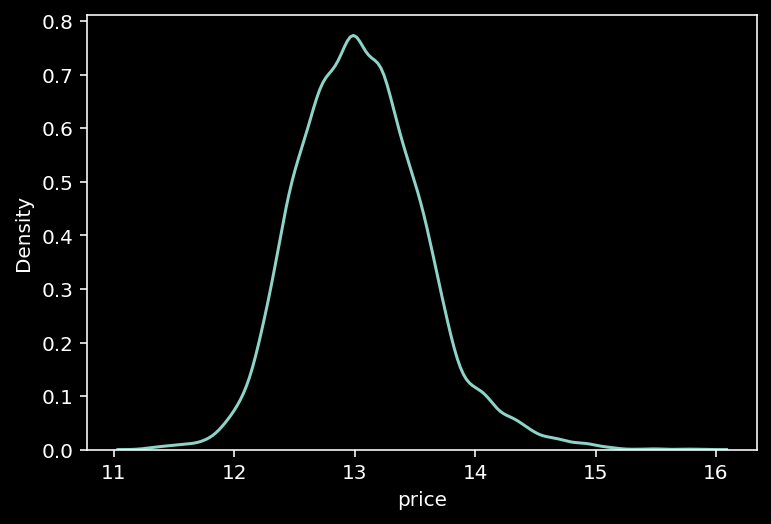

In [56]:
# Î°úÍ∑∏Î≥ÄÌôò
y = np.log1p(y)
# Î∂ÑÌè¨Î•º ÏãúÍ∞ÅÏ†ÅÏúºÎ°ú ÌôïÏù∏
sns.kdeplot(y)
plt.show()

## 2. Î™®Îç∏ ÌäúÎãù

In [57]:
#Î™®Îç∏Îì§

random_state=2022

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

### 2.1. Î™®Îç∏ ÌäúÎãùÏùÑ ÏúÑÌï¥ ÏïûÏÑú Ï†ïÏùòÌïú Ìï®ÏàòÎì§ÏùÑ Ï†ïÎ¶¨Ìï¥Î≥¥Ïûê

#### Ïù∏ÏûêÎ°ú Î∞õÏùÑ Í∞íÎì§Ïóê Î°úÍ∑∏Ìï®ÏàòÍ∞Ä Ï†ÅÏö©ÎêòÏñ¥ ÏûàÏúºÎØÄÎ°ú ÏßÄÏàòÌï®ÏàòÎ•º Ï†ÅÏö©Ìï¥Ï§ÄÎã§.
> ```def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))```

#### ÏïôÏÉÅÎ∏î Ìï† Î™®Îç∏Îì§Ïóê ÎåÄÌïú Í∞úÎ≥Ñ RMSE Ï†êÏàòÎ•º ÎîïÏÖîÎÑàÎ¶¨Î°ú Ï†ÄÏû•ÌïòÎäî Ìï®Ïàò

Ïù∏Ïûê ÏÑ§Î™Ö
- models : ÏïôÏÉÅÎ∏î Ìï† Î™®Îç∏Îì§Ïùò Î¶¨Ïä§Ìä∏
- train : ÌïôÏäµ Îç∞Ïù¥ÌÑ∞
- y : ÌÉÄÍ≤ü Îç∞Ïù¥ÌÑ∞

>```def get_scores(models, train, y): 
        Îπà ÎîïÏÖîÎÑàÎ¶¨ ÏÉùÏÑ±
        df = {} 
        ÏïôÏÉÅÎ∏îÌï† Î™®Îç∏ Î¶¨Ïä§Ìä∏Î•º ÎåÄÏÉÅÏúºÎ°ú Î∞òÎ≥µÎ¨∏ ÏûëÏÑ±
        for model in models:
            model_name = model.__class__.__name__
        Îç∞Ïù¥ÌÑ∞ Ïä§ÌîåÎ¶ø
            X_train, X_test, y_train, y_test = train_test_split(
            train, y, random_state=random_state, test_size=0.2)        
            model.fit(X_train, y_train)
        ÌÉÄÍ≤ü ÏòàÏ∏°
            y_pred = model.predict(X_test)
        Î™®Îç∏Î™ÖÏùÑ ÌÇ§, ÏïûÏÑú Ï†ïÏùòÌïú rmseÍ∞íÏùÑ Î∞∏Î•òÎ°ú Î∞õÏùå
            df[model_name] = rmse(y_test, y_pred)
            score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
        Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ ÌòïÌÉúÎ°ú ÏãúÍ∞ÅÌôî Ìïú Í≤ÉÏùÑ Î¶¨ÌÑ¥ÏúºÎ°ú Î∞õÏùå
        return score_df```

#### Í∑∏Î¶¨Îìú ÏÑúÏπò
Ïù∏Ïûê ÏÑ§Î™Ö
- model : Í∑∏Î¶¨ÎìúÏÑúÏπòÎ°ú ÌäúÎãùÌï† Î™®Îç∏Î™Ö
- train, y : ÌïôÏäµ, ÌÉÄÍ≤ü Îç∞Ïù¥ÌÑ∞
- param_grid : ÌäúÎãùÌï† ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞Ïùò Ï¢ÖÎ•ò(ÎîïÏÖîÎÑàÎ¶¨ ÌòïÌÉú)
- verbose : 
    - 0 : ÏïÑÎ¨¥ Í≤ÉÎèÑ Ï∂úÎ†•ÌïòÏßÄ ÏïäÏäµÎãàÎã§.
    - 1 : ÌõàÎ†®Ïùò ÏßÑÌñâÎèÑÎ•º Î≥¥Ïó¨Ï£ºÎäî ÏßÑÌñâ ÎßâÎåÄÎ•º Î≥¥Ïó¨Ï§çÎãàÎã§.
    - 2 : ÎØ∏Îãà Î∞∞ÏπòÎßàÎã§ ÏÜêÏã§ Ï†ïÎ≥¥Î•º Ï∂úÎ†•Ìï©ÎãàÎã§.
- n_jobs : Í∑∏Î¶¨ÎìúÌÉêÏÉâÏóê ÏÇ¨Ïö©Ìï† CPUÏàò


>```def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    GridSearchCV Î™®Îç∏Î°ú Ï¥àÍ∏∞Ìôî
        - Ï†êÏàòÎäî n_mseÎ°ú Ï∏°Ï†ï
        - cv : ÍµêÏ∞®Í≤ÄÏ¶ùÏùÑ ÏúÑÌïú ÌïôÏäµÎç∞Ïù¥ÌÑ∞ Î∂ÑÌï† Ïàò
        grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error',
                                  cv=5, verbose=verbose, n_jobs=n_jobs)
    Î™®Îç∏ fitting
        grid_model.fit(train, y)
    Í≤∞Í≥ºÍ∞í Ï†ÄÏû•
        params = grid_model.cv_results_['params']
        score = grid_model.cv_results_['mean_test_score']
    Îç∞Ïù¥ÌÑ∞ ÌîÑÎ†àÏûÑ ÏÉùÏÑ±
        results = pd.DataFrame(params)
        results['score'] = score
    RMSLE Í∞í Í≥ÑÏÇ∞ ÌõÑ Ï†ïÎ†¨
        results['RMSLE'] = np.sqrt(-1 * results['score'])
        results = results.sort_values('RMSLE')
    return results```

#### Ï†úÏ∂úÏö© ÌååÏùº ÏóÖÎ°úÎìúÎ•º ÏúÑÌïú Ìï®Ïàò

>```def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    dir_path = '/aiffel/aiffel/Exploration/lets_kaggle/kaggle_kakr_housing/data/'
    submission_path = join(dir_path, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(dir_path, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))```

### 2.2. Î™®Îç∏Îì§Ïùò RMSEÎ•º ÌôïÏù∏Ìï¥Î≥¥Ïûê.

In [58]:
get_scores(models, train, y)

RMSE
RandomForestRegressor      135139.591426
GradientBoostingRegressor  130361.233685
XGBRegressor               127865.518649
LGBMRegressor              120099.067237

### 2.3. Ï†êÏàòÍ∞Ä ÎÜíÏùÄ LGBMÎ∂ÄÌÑ∞ ÏßÑÌñâÌï¥Î≥¥Ïûê

#### Î™á Î≤àÏùò Í∑∏Î¶¨Îìú ÌÉêÏÉâÏùÑ ÏßÑÌñâÌï¥ Î≥¥ÏïòÎã§.
- Î∂ÄÏä§ÌåÖ ÌÉÄÏûÖÏùò ÎûúÎç§Ìè¨Î†àÏä§Ìä∏Îäî ÏàòÏπòÎ•º ÌôïÏù∏Ìï† Ïàò ÏóÜÏóàÎã§.
- Î∞òÎ≥µ ÌöüÏàòÎäî 500Ïù¥Ìïò 1000Ïù¥ÏÉÅÏóêÏÑú Ï†êÏàòÍ∞Ä Ï¢ãÏßÄ ÏïäÏïòÎã§.
- depthÎäî 5~ 30 ÏÇ¨Ïù¥Î•º ÌôïÏù∏Ìï¥ Î≥∏ Í≤∞Í≥º 10Ïù¥ Í∞ÄÏû• Ï†ÅÏ†ï ÏàòÏπòÎ°ú Î≥¥ÏòÄÎã§.
- Ïù¥Ïô∏ÏóêÎèÑ ÎßéÏùÄ ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞ Ïù∏ÏûêÍ∞Ä ÏûàÏóàÏúºÎÇò ÏãúÍ∞ÑÏóê ÎπÑÌï¥ Ïú†Ìö®ÏÑ±Ïù¥ ÎÇÆÏïòÎã§.

In [71]:
param_grid = {
    'n_estimators': [500, 650, 800],
    'max_depth': [1, 5, 10],
    'learning_rate' : [0.05, 0.1]
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


learning_rate  max_depth  n_estimators     score     RMSLE
7            0.05         10           650 -0.025880  0.160873
8            0.05         10           800 -0.025904  0.160946
6            0.05         10           500 -0.025927  0.161020
15           0.10         10           500 -0.026245  0.162004
5            0.05          5           800 -0.026276  0.162097
4            0.05          5           650 -0.026368  0.162382
16           0.10         10           650 -0.026376  0.162406
12           0.10          5           500 -0.026456  0.162653
13           0.10          5           650 -0.026510  0.162818
17           0.10         10           800 -0.026552  0.162947
3            0.05          5           500 -0.026618  0.163151
14           0.10          5           800 -0.026665  0.163294
11           0.10          1           800 -0.037257  0.193021
10           0.10          1           650 -0.037989  0.194908
9            0.10          1           500 -0.039049  0.197607
2            0.05          1           800 -0.040219  0.200546
1            0.05          1           650 -0.041528  0.203785
0            0.05          1           500 -0.043448  0.208442

In [91]:
# Ï†êÏàòÍ∞Ä Í∞ÄÏû• Ï¢ãÏùÄ ÌååÎùºÎØ∏ÌÑ∞Î°ú ÌïôÏäµ/ÏòàÏ∏°
model = LGBMRegressor(max_depth=10, n_estimators=650, learning_rate=0.5, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)


In [92]:
# Ïä§ÏºÄÏùºÎßÅ Î≥µÍµ¨
prediction = np.expm1(prediction)

In [93]:
submission_path = join(dir_path, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

id   price
0  15035  100000
1  15036  100000
2  15037  100000
3  15038  100000
4  15039  100000

In [94]:
#ÏÉàÎ°ú ÌïôÏäµÌïú ÏòàÏ∏°Í∞íÏùÑ Ï†ÅÏö©
submission['price'] = prediction
submission.head()

id         price
0  15035  5.474336e+05
1  15036  5.460958e+05
2  15037  1.252149e+06
3  15038  2.996389e+05
4  15039  2.790290e+05

In [95]:
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(dir_path, 'lgbm', '0.160873')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

/aiffel/aiffel/Exploration/lets_kaggle/kaggle_kakr_housing/data//submission_lgbm_RMSLE_0.160873.csv


In [98]:
def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    dir_path = '/aiffel/aiffel/Exploration/lets_kaggle/kaggle_kakr_housing/data/'
    submission_path = join(dir_path, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(dir_path, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [99]:
save_submission(model, train, y, test, 'lgbm', rmsle='0.01608')

/aiffel/aiffel/Exploration/lets_kaggle/kaggle_kakr_housing/data//submission_lgbm_RMSLE_0.01608.csv saved!


#### Ï†êÏàòÎäî ÌïúÏ∞∏ Î∂ÄÏ°±ÌñàÎã§(..)

### 2.4. XGB Î™®Îç∏ÏùÑ Ïù¥Ïö©Ìï¥Î≥¥Ïûê.

In [70]:
train_data_path = join(dir_path, 'train.csv')
test_data_path = join(dir_path, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

# dateÎ•º Ï†ïÏàòÌòï Îç∞Ïù¥ÌÑ∞Î°ú Ï†ÑÏ≤òÎ¶¨
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)

# ÌÉÄÍ≤ü Îç∞Ïù¥ÌÑ∞ price Î∂ÑÎ¶¨
y = train['price']
del train['price']

# id Ïª¨Îüº Ï†úÍ±∞
del train['id']

# ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ Ï†ÑÏ≤òÎ¶¨
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

del test['id']
y = np.log1p(y)

In [69]:
# XGBÌöåÍ∑Ä Î™®Îç∏Ïóê ÎåÄÌïú Í∑∏Î¶¨Îìú ÌÉêÏÉâ
# Í≥ÑÏÜç ÏïÑÎûòÏôÄ Í∞ôÏùÄ Í≤ΩÍ≥†Í∞Ä Î∞úÏÉùÌïòÍ≥† Í≤∞Í≥ºÍ∞Ä ÎÇòÏò§ÏßÄ ÏïäÏïòÎã§.
# ÎçïÎ∂ÑÏóê Ïó¨Îü¨ ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞Ïóê ÎåÄÌï¥ÏÑú ÏóÑÏ≤≠ÎÇòÍ≤å Í≤ÄÏÉâÌñàÎã§.
# Í≤∞Í≥ºÏ†ÅÏúºÎ°ú Ìïú Î≤àÎèÑ Í≤∞Í≥ºÎ•º ÌôïÏù∏ÌïòÏßÄ Î™ªÌï¥ Ïù¥Ï†Ñ Ïö∞ÏàòÎÖ∏ÎìúÎ•º ÌôïÏù∏Ìï¥Î≥¥ÏïòÎçîÎãà Ìïú Î≤à Ïã§ÌñâÏóê ÏãúÍ∞ÑÏù¥ ÏóÑÏ≤≠ Í±∏Î†∏Îã§Îäî ÌöåÍ≥†Î•º ÌôïÏù∏ÌñàÎã§.
# ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞Î•º ÏàòÎèôÏúºÎ°ú Ï°∞Ï†àÌï¥Í∞ÄÎ©∞ Í≤∞Í≥ºÍ∞íÏùÑ ÌôïÏù∏Ìï¥Î≥¥Í∏∞Î°ú Í≤∞Ï†ï.
param_grid = {
   'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 500, 1000],
    'max_depth': [3, 5, 7, 9]
}

model = XGBRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=1, n_jobs=5)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warni

KeyboardInterrupt: 

In [105]:
model = XGBRegressor(
    learning_rate = 0.1,
    n_estimators = 1500,
    max_depth= 5,
    min_child_weight = 1,
    eval_metric = 'rmse',
    scale_pos_weight = 1,
    objective =  'reg:squarederror',
    random_state = random_state
)
model.fit(train, y)
prediction = model.predict(test)

In [106]:
prediction = np.expm1(prediction)

In [107]:
submission_path = join(dir_path, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

id   price
0  15035  100000
1  15036  100000
2  15037  100000
3  15038  100000
4  15039  100000

In [108]:
submission['price'] = prediction
submission.head()

id         price
0  15035  5.303379e+05
1  15036  4.650724e+05
2  15037  1.446864e+06
3  15038  3.061110e+05
4  15039  3.283259e+05

In [109]:
save_submission(model, train, y, test, 'XGB', rmsle='0.163')

/aiffel/aiffel/Exploration/lets_kaggle/kaggle_kakr_housing/data//submission_XGB_RMSLE_0.163.csv saved!


#### XGBÎ™®Îç∏ ÌäúÎãù
- Í∑∏Î¶¨ÎìúÏÑúÏπò Í≥ºÏ†ïÏóêÏÑú ÍµêÏ∞®Í≤ÄÏ¶ù Î≥ÄÏù∏Îì§ÏùÑ ÏµúÏÜåÎ°ú Ï§ÑÏó¨ÎèÑ ÎÑàÎ¨¥ ÎÑàÎ¨¥ ÎÑàÎ¨¥..ÎäêÎ†∏Îã§.
- Íµ¨Í∏ÄÎßÅÏùÑ ÌÜµÌï¥ XGBÎ™®Îç∏Ïùò ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞Îì§ÏùÑ ÌïôÏäµÌñàÎã§.
- ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞Ïùò Ï¢ÖÎ•òÎèÑ ÏóÑÏ≤≠ ÎßéÍ≥†, Î≤ÑÏ†ÑÏóê Îî∞Îùº Î≥ÄÌôîÍ∞Ä ÎßéÏùå.
- Í∑∏ ÏôÄÏ§ëÏóê, ÏïÑÎûò Î∏îÎ°úÍ∑∏Ïóê Í∞ÄÏû• ÏâΩÍ≤å Ï†ïÎ¶¨Í∞Ä ÎêòÏñ¥ÏûàÏóàÎã§.
> https://riverzayden.tistory.com/17


## 3. Î™©Ìëú Ïä§ÏΩîÏñ¥ Îã¨ÏÑ±

### XGBRegressionÏúºÎ°ú Î™©Ìëú Ïä§ÏΩîÏñ¥Î•º Îã¨ÏÑ±ÌñàÎã§.
![](./109526.jpg)

### ÏúÑ Ï†úÏ∂úÏóê ÏÇ¨Ïö©Ìïú Î™®Îç∏Í≥º ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞ ÏΩîÎìú
>```model = XGBRegressor(
    learning_rate = 0.1,
    n_estimators = 1500,
    max_depth= 5,
    min_child_weight = 1,
    eval_metric = 'rmse',
    scale_pos_weight = 1,
    objective =  'reg:squarederror',
    random_state = random_state
)```

In [110]:
# Ìï¥ÎãπÌïòÎäî ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞ ÏàòÏπòÎ°ú RMSLEÎ•º ÌôïÏù∏Ìï¥Î≥¥ÏïòÎã§. 
param_grid = {
   'learning_rate': [0.1],
    'n_estimators': [1500],
    'max_depth': [5]
}

model = XGBRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=1, n_jobs=1)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


learning_rate  max_depth  n_estimators    score    RMSLE
0            0.1          5          1500 -0.02668  0.16334

## 4. ÎßàÏπòÎ©∞

### Í∏∞ÏñµÏóê ÎÇ®Îäî ÌïôÏäµ ÎÇ¥Ïö©



- ÏïôÏÉÅÎ∏î(Î∏îÎ†åÎî©) Í∏∞Î≤ïÎì§Ïóê ÎåÄÌïú Ïù¥Î°†Ï†Å ÎÇ¥Ïö©.


- ÌäπÌûà bagging Î∞©ÏãùÏù¥ ÎûúÎç§Ìè¨Î†àÏä§Ìä∏ Î™®Îç∏ Í∑∏ ÏûêÏ≤¥ÏôÄ ÎπÑÏä∑ÌïòÍ≤å ÎäêÍª¥ÏßÑ Î∂ÄÎ∂ÑÏù¥ Ìù•ÎØ∏Î°úÏõ†Îã§.


- Í∑∏Î¶¨ÎìúÏÑúÏπòÏôÄ ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞ ÌäúÎãù


### Ïñ¥Î†§Ïõ†Îçò Ï†ê


- XGBoostÏóê ÎåÄÌïú Í∑∏Î¶¨ÎìúÏÑúÏπòÍ∞Ä Ïûò ÏûëÎèôÌïòÏßÄ ÏïäÏïòÎçò Ï†ê (ÏõêÎûò ÏóÑÏ≤≠ ÎäêÎ¶¨Îã§Îäî ÎÇ¥Ïö©ÏùÑ ÎßéÏù¥ Ï∞æÏïÑÎ≥¥Í≤å ÎêòÍ∏¥ ÌñàÏßÄÎßå)


- ÏãúÍ∞ÅÌôîÎ•º ÏúÑÌïú pandas ÏÇ¨Ïö©Ïù¥ ÎÑàÎ¨¥ Í∑ÄÏ∞ÆÍ≤å ÎäêÍª¥Ï°åÎã§. 
> Ìù•ÎØ∏Î°≠Í≤å ÎäêÍª¥ÏßÄÎäî ÌîÑÎ°úÏ†ùÌä∏Ïóê Ï∞∏Í∞ÄÌïúÎã§Î©¥ Ï†ÑÏ≤òÎ¶¨ Í≥ºÏ†ïÏóêÏÑú Ï†ÅÍ∑πÏ†ÅÏúºÎ°ú Ïù¥Ïö©Ìï† Í≤É Í∞ôÏßÄÎßå ÌïôÏäµÏùÑ ÏúÑÌïú Ïã§Ïäµ Îã®Í≥ÑÏóêÏÑúÎäî ÎßéÏù¥ ÏùòÎØ∏Í∞Ä Ìá¥ÏÉâÎêòÎäî ÎäêÎÇåÏù¥ Îì§Ïñ¥ Í∑∏Îü∞ Í≤É Í∞ôÎã§.


### Ï∂îÍ∞ÄÎ°ú Ìï¥Î≥¥Í≥† Ïã∂ÏùÄ Ï†ê
- Í∏∞Î∞ò ÏßÄÏãùÏù¥ ÌîÑÎ°úÏ†ùÌä∏ ÏßÑÌñâÏóê ÌÅ∞ Ï∞®ÏßàÏùÑ Ï£ºÏßÄ ÏïäÏùÑ Ï†ïÎèÑÍ∞Ä ÎêòÎ©¥ Ï≤òÏùåÎ∂ÄÌÑ∞ Ìï¥Î≥¥Í≥† Ïã∂Îã§.

    : Îç∞Ïù¥ÌÑ∞ Î∂ÑÏÑùÍ≥º Ï†ÑÏ≤òÎ¶¨, Î™®Îç∏ ÏÑ†Ï†ï, ÏµúÏ†ÅÌôî Îì±Îì±..

### Ï¥ùÌèâ
> Í∑∏Î¶¨Îìú ÌÉêÏÉâÏù¥ÎÇò ÏûÑÎ≤†Îî© Îì±ÏùÑ Ìè¨Ìï®Ìï¥, ÌïôÏäµ ÏãúÍ∞Ñ ÏûêÏ≤¥Í∞Ä Í∏¥ Í≤ΩÏö∞Í∞Ä ÎßéÏïÑÏßÄÍ≥† ÏûàÎã§.
>
>Ïù¥Î°†Ïóê ÎåÄÌïú ÌïôÏäµÏùÄ Í≥ºÏ†ïÏóêÏÑú 2Ï§ë 3Ï§ëÏúºÎ°ú ÏßÑÌñâÎêòÍ≥† ÏûàÏúºÎãà ÏïûÏúºÎ°úÏùò ÏùµÏä§ÌîåÎ°úÎ†àÏù¥ÏÖò ÏßÑÌñâÏùÄ Ï£ºÏñ¥ÏßÑ Î™©ÌëúÎ•º ÏÑ±Ï∑®ÌïòÎäî Í≤ÉÏóê Îçî ÏßëÏ§ëÌï¥ÏÑú ÏßÑÌñâÌïòÎäî Í≤ÉÏù¥ Ï¢ãÏùÑ Í≤É Í∞ôÎã§.